In [6]:
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point,LineString
from shapely.geometry.polygon import Polygon
import operator

In [116]:
class Geometrie:
    def __init__(self,polygon):
        self.main_polygon = polygon
        self._internal_polygons = {}
        self._internal_points = {}        
        bounds = np.array(polygon.bounds).reshape(2,2).transpose()
        self.dims = bounds[:,1]-bounds[:,0] # row 0 : x // row 1 : y
        self.min_dim = self.dims.min()
        self.max_dim = self.dims.max()
        
            
    
    def internal_points(self,names=None):
        for name,polys in self._internal_points.items():
            if names is None or name in names:
                for p in polys:
                    yield p  
                
    def internal_polygons(self,names=None):
        for name,polys in self._internal_polygons.items():
            if names is None or name in names:
                for p in polys:
                    yield p     
    
    def internal_point_names(self):
        return list(self._internal_points.keys())     
    
    def internal_polygon_names(self):
        return list(self._internal_polygons.keys())
        
        
    def add_tremie(self,ratio_z_x=1,ratio=0.1,max_iter=1000,ratio_distance_min=1,name="tremie"):
        rng = np.random.default_rng()
        if name not in self._internal_polygons:
            self._internal_polygons[name] = []
        dim = self.min_dim*ratio
        skip = True
        iter_ = 0
        while skip and iter_<=max_iter:
            skip = False
            iter_ += 1
            trans = rng.random((2,))
            tremie = random_polygon2(ratio_z_x=ratio_z_x,scale=ratio,trans=trans)
            if tremie.within(self.main_polygon):
                if tremie.distance(self.main_polygon.exterior)<=ratio_distance_min*dim:
                    skip = True
                if not skip:
                    for tr in self.internal_polygons():
                        if tremie.intersects(tr):
                            skip = True
                            break
                        if tremie.distance(tr.exterior)<=ratio_distance_min*dim:
                            skip = True
                            break
            else:
                skip = True
        if not skip:
            self._internal_polygons[name].append(tremie)
            return True
        return False
    
    def add_interior_point(self,center_area=None,ratio_area=1,ratio_distance_min=0.001,max_iter=1000,name="point"):
        rng = np.random.default_rng()
        if name not in self._internal_points:
            self._internal_points[name] = []
        dim = self.max_dim*ratio_area
        skip = True
        iter_ = 0
        while skip and iter_<=max_iter:
            skip = False
            iter_ += 1
            point = rng.random((2,))*dim        
            if center_area:
                point = point + np.array(center_area)
            point_ = Point(point)
            if point_.within(self.main_polygon):
                if point_.distance(self.main_polygon.exterior)<=ratio_distance_min*dim:
                    skip = True
                if not skip:
                    for tr in self.internal_polygons():
                        if point_.within(tr):
                            skip = True
                            break
                        if point_.distance(tr.exterior)<=ratio_distance_min*dim:
                            skip = True
                            break
            else:
                skip = True
            if not skip:
                self._internal_points[name].append(point_)
                return True
        return False
    
                
            
        
        
    def plot(self,ax=None):
        ax = plot_polygon(self.main_polygon,ax=ax)
        for name,polys in self._internal_polygons.items():
            for p in polys:
                ax = plot_polygon(p)
                
        for name,pts in self._internal_points.items():
            coords = []
            for pt in pts:
                coords.append(pt.coords[0])
            coords = np.array(coords)
            print(coords.shape)
            ax.scatter(coords[:,0],coords[:,1],label=name,marker="x")
        return ax
        
        
    
        
        


In [117]:
(Point(0,1).coords[0])

(0.0, 1.0)

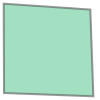

In [118]:
geom = Geometrie(random_polygon2())
geom.main_polygon

<AxesSubplot:>

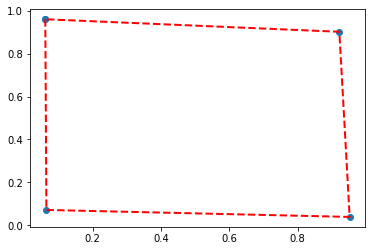

In [119]:
geom.plot()

In [120]:
geom.add_tremie()
geom.add_tremie()
geom.add_tremie(ratio=0.05)

True

<AxesSubplot:>

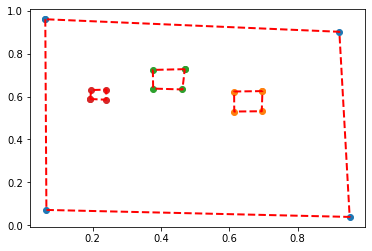

In [121]:
geom.plot()

In [122]:
geom.add_interior_point()
geom.add_interior_point()
geom.add_interior_point()

True

(3, 2)


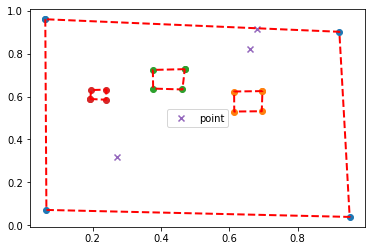

In [126]:
ax = geom.plot()
ax.legend()

In [124]:
def plot_hull(hull,ax=None):
    n = hull.vertices.shape[0]
    points = hull.points
    if ax is None:
        ax = plt.gca()
    ax.scatter(hull.points[:,0],hull.points[:,1])
    ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    ax.plot(points[hull.vertices[::n-1],0], points[hull.vertices[::n-1],1], 'r--', lw=2)
    ax.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
    return ax
    
def random_polygon(n_vertices):
    n = 0
    rng = np.random.default_rng()
    while n!=n_vertices:
        points = rng.random((n_vertices,2))   # 30 random points in 2-D
        hull = ConvexHull(points)
        n = hull.vertices.shape[0]
    return hull

def random_polygon2(*ranges):
    n_vertices = len(ranges)
    points = []
    rng = np.random.default_rng() 
    for range_ in ranges:
        point = rng.random((2,))
        for coord in range(2):
            point[coord] = range_[0,coord] + (range_[1,coord]-range_[0,coord])*point[coord]
        points.append(point)
    try:
        hull = ConvexHull(points)
    finally:
        pass
    return hull.points[hull.vertices,:]



def random_polygon2(ratio_z_x=1,percent_x=0.1,percent_z=0.1,scale=1,trans=[0,0]):
    ranges = [
            np.array([[0,0],
              [percent_x,percent_z*ratio_z_x]]),
    np.array([[1-percent_x,0],
              [1.0,percent_z*ratio_z_x]]),
    np.array([[1-percent_x,ratio_z_x-percent_z*ratio_z_x],
              [1.0,ratio_z_x]]),
    np.array([[0,ratio_z_x-percent_z*ratio_z_x],
              [percent_x,ratio_z_x]])
    ]
    
    n_vertices = len(ranges)
    points = []
    rng = np.random.default_rng() 
    for range_ in ranges:
        point = rng.random((2,))
        for coord in range(2):
            point[coord] = trans[coord] + (range_[0,coord] + (range_[1,coord]-range_[0,coord])*point[coord])*scale
        points.append(point)
    try:
        hull = ConvexHull(points)
    finally:
        pass
    return Polygon(hull.points[hull.vertices])

def plot_polygon(polygon,ax=None):
    points = np.array(list(polygon.exterior.coords))
    if ax is None:
        ax = plt.gca()
    ax.scatter(points[:,0],points[:,1])
    ax.plot(points[:,0], points[:,1], 'r--', lw=2)
    return ax
    

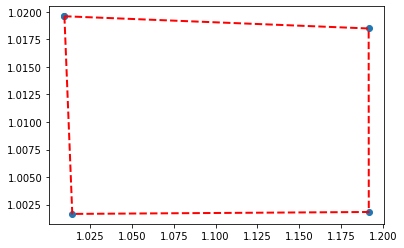

In [66]:
polygon = random_polygon2(0.1,scale=0.2,trans=[1,1])
ax = plot_polygon(polygon)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

<AxesSubplot:>

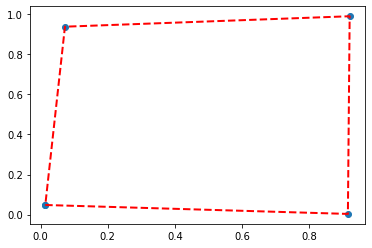

In [229]:
# hull = random_polygon(4)
polygon = random_polygon2()
# plot_hull(hull);
plot_polygon(polygon)

In [183]:
from shapely.geometry import Point,LineString
from shapely.geometry.polygon import Polygon
def inside_points(hull,n_points,not_allowed_poly=[]):
    results = []
    rng = np.random.default_rng()
    polygon = Polygon(hull.points[hull.vertices])
    lines = list(map(LineString,hull.points[hull.simplices]))
    polys_to_test = []
    for h in not_allowed_poly:
        polys_to_test.append(Polygon(h.points[h.vertices]))
        
    while len(results)<n_points:
        np_point = rng.random((2,))
        point = Point(np_point)
        if polygon.contains(point) and not any(map(point.within,lines)):
            skip = False
            for poly_to_test in polys_to_test:
                if poly_to_test.contains(point) or point.touches(poly_to_test):
                    skip = True
                    break
            if not skip:
                results.append(np_point)
    return np.vstack(results)
            

In [180]:
import itertools,operator
def inside_polygons(hull,n_polygons,n_vertices=4):
    results = []
    rng = np.random.default_rng()
    polygon = Polygon(hull.points[hull.vertices])
    lines = list(map(LineString,hull.points[hull.simplices]))
    while len(results)<n_polygons:
        hull_tmp = random_polygon(n_vertices)
        polygon_tmp = Polygon(hull_tmp.points[hull_tmp.vertices])
        points_tmp = list(map(Point,hull_tmp.points[hull_tmp.vertices]))
        if not polygon_tmp.within(polygon):
            continue # polygon tmp en dehors du polygone
        skip = False
        for l,p in itertools.product(lines,points_tmp):
            if l.contains(p):
                skip = True
                break # un des noeuds de polygon tmp sur le d'un autre 
        for (hull_to_test,poly_to_test),p in itertools.product(results,points_tmp):
            if poly_to_test.intersects(polygon_tmp):
                skip = True
                break   # un des noeuds de polygon tmp dans un poly déjà là
        if not skip:
            results.append((hull_tmp,polygon_tmp))
    return list(map(operator.itemgetter(0),results))


def inside_polygons2(hull,n_polygons,n_vertices=4):
    results = []
    rng = np.random.default_rng()
    polygon = Polygon(hull.points[hull.vertices])
    lines = list(map(LineString,hull.points[hull.simplices]))
    while len(results)<n_polygons:
        hull_tmp = random_polygon(n_vertices)
        polygon_tmp = Polygon(hull_tmp.points[hull_tmp.vertices])
        points_tmp = list(map(Point,hull_tmp.points[hull_tmp.vertices]))
        if not polygon_tmp.within(polygon):
            continue # polygon tmp en dehors du polygone
        skip = False
        for l,p in itertools.product(lines,points_tmp):
            if l.contains(p):
                skip = True
                break # un des noeuds de polygon tmp sur le d'un autre 
        for (hull_to_test,poly_to_test),p in itertools.product(results,points_tmp):
            if poly_to_test.intersects(polygon_tmp):
                skip = True
                break   # un des noeuds de polygon tmp dans un poly déjà là
        if not skip:
            results.append((hull_tmp,polygon_tmp))
    return list(map(operator.itemgetter(0),results))


def inside_polygons3(polygon,n_polygons,ratio_z_x=0.1):
    results = []
    rng = np.random.default_rng()
    polygon = Polygon(hull.points[hull.vertices])
    lines = list(map(LineString,hull.points[hull.simplices]))
    while len(results)<n_polygons:
        hull_tmp = random_polygon(n_vertices)
        polygon_tmp = Polygon(hull_tmp.points[hull_tmp.vertices])
        points_tmp = list(map(Point,hull_tmp.points[hull_tmp.vertices]))
        if not polygon_tmp.within(polygon):
            continue # polygon tmp en dehors du polygone
        skip = False
        for l,p in itertools.product(lines,points_tmp):
            if l.contains(p):
                skip = True
                break # un des noeuds de polygon tmp sur le d'un autre 
        for (hull_to_test,poly_to_test),p in itertools.product(results,points_tmp):
            if poly_to_test.intersects(polygon_tmp):
                skip = True
                break   # un des noeuds de polygon tmp dans un poly déjà là
        if not skip:
            results.append((hull_tmp,polygon_tmp))
    return list(map(operator.itemgetter(0),results))

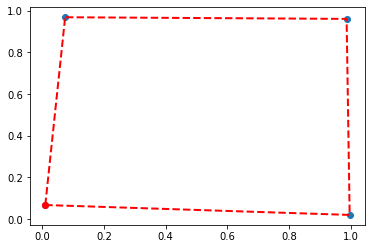

In [198]:
ax = plot_hull(hull)
hs = inside_polygons(hull,4)

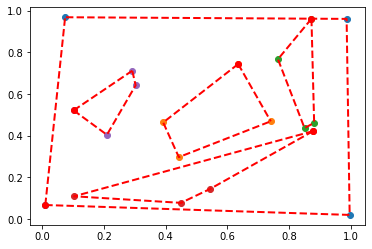

In [199]:
plt.figure()
ax = plot_hull(hull)
for h in hs:
    plot_hull(h,ax=ax)

In [200]:
points = inside_points(hull,15,hs)

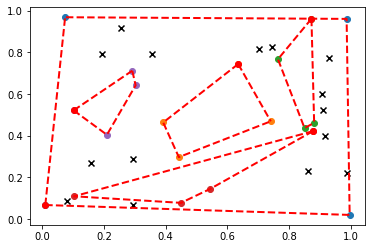

In [201]:
plt.figure()
ax = plot_hull(hull)
for h in hs:
    plot_hull(h,ax=ax)
ax.scatter(points[:,0],points[:,1],c="k",marker="x")

In [188]:
points_forces = inside_points(hull,10,hs)

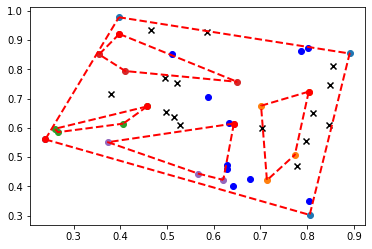

In [190]:
plt.figure()
ax = plot_hull(hull)
for h in hs:
    plot_hull(h,ax=ax)
ax.scatter(points[:,0],points[:,1],c="k",marker="x")
ax.scatter(points_forces[:,0],points_forces[:,1],c="b",marker="o")

In [129]:
from pathlib import Path
dest = Path("/mnt/c/users/maxime.conti/Desktop/test_project")

In [460]:
def filtre_noeuds(noeuds,tremies):
    result = noeuds.copy()
    for tr in tremies:

        a = np.full((result.shape[0],),True)
        for coord in range(2):
            a = np.vstack((a,result[:,coord]<=tr[coord+4],result[:,coord]>=tr[coord]))
        result = result[np.logical_not(a.all(axis=0))]
    return result

# DATA

In [26]:
test = np.full((10,2),1)
for t in testt:
    print(t[0:]+t[0:])
test[:,0:1]

[2 2]
[2 2]
[2 2]
[2 2]
[2 2]
[2 2]
[2 2]
[2 2]
[2 2]
[2 2]


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
dim_x = 10
dim_z = 10



# APPUIS PONCTUELS
# TODO A GENERERER ALEATOIREMENT
appuis_ponctuels = np.array(
[
        [1.1,1.1],
        [0.5,0.5],
        [2,5],
        [8,3],
        [8,8]
])


# TREMIES EVENTUELLES
# TODO A GENERERER ALEATOIREMENT
tremies = np.array(
[
    [1,0.9,2,2],
    [8,8,0.5,0.5],
    
])
# tremies = np.array([])

# MATERIAUX
mo = 11e6
nu = 0
ep = 0.1


# MAILLAGE
if tremies.shape[0]:
    tm = tremies[:,0:2].min()/3
else:
    tm = min(dim_x/20,dim_z/20)

# CALCUL LES EXTREMITES DES TREMIES
if tremies.shape[0]:
    end = np.vstack((tremies[:,0] + tremies[:,2],tremies[:,1] + tremies[:,3])).transpose()
    tremies = np.hstack((tremies,end))

    
# SORT LES POINTS HORS TREMIES
appuis_ponctuels = filtre_noeuds(appuis_ponctuels,tremies)

NameError: name 'filtre_noeuds' is not defined

In [479]:
# TIRAGE FORCES PONCTUELLES
n_forces = np.random.randint(20)
forces_ponctuelles =np.random.rand(n_forces,2)
forces_ponctuelles[:,0] = forces_ponctuelles[:,0]*dim_x
forces_ponctuelles[:,1] = forces_ponctuelles[:,1]*dim_z
forces_ponctuelles = filtre_noeuds(forces_ponctuelles,tremies)
forces_ponctuelles

array([[9.87058535, 1.27562086],
       [0.50636817, 5.14324175],
       [4.97067996, 5.58249555],
       [7.28014334, 6.12617721],
       [2.9572292 , 2.95595669],
       [6.45890538, 7.54727576],
       [4.04405867, 4.8969322 ],
       [6.26437682, 4.6450653 ],
       [1.81629033, 7.5767612 ],
       [6.77831448, 1.88347855],
       [5.88836265, 5.98040211],
       [4.88679329, 7.27199988],
       [1.35810771, 8.2584352 ],
       [6.95293388, 4.72683144],
       [6.90378028, 3.8146867 ]])

# DDON

In [480]:
no = 100

In [481]:
def cf(no,x_,z_,dim_x,dim_z,td=None):
    no_end = no+400
    s_no = ' '.join(map(str,np.arange(no,no_end,100)))
    s_td = ""
    if td is not None:
        s_td = f"TD {td}"
    s = f"""\
NO {s_no} XX {x_} {x_+dim_x} {x_+dim_x} {x_} ZZ {z_} {z_} {z_+dim_z} {z_+dim_z} YY 0
CF {no} NO {s_no} {s_td}
"""
    return no_end+100,s   


In [482]:
s=f"""\
** GEO TM {tm}
TD 1 EP {ep} MO {mo} NU {nu}
"""

In [483]:
# CONTOUR EXTERIEUR
no_cf_ext = no
no,adds = cf(no,0,0,dim_x,dim_z)
s += adds

In [484]:
# CONTOURS INTERIEURS
no_cf_ints = []
for x_,z_,dimx_,dimz_,*rest in tremies:
    no_cf_ints.append(no)
    no,adds = cf(no,x_,z_,dimx_,dimz_)
    s += adds

In [485]:
# NO APPUIS
no_end = no + appuis_ponctuels.shape[0]*100
no_app_int = np.arange(no,no_end,100)
no = no_end
s_no_app_int = " ".join(map(str,no_app_int))
s_x = ",".join(map(str,appuis_ponctuels[:,0]))
s_z = ",".join(map(str,appuis_ponctuels[:,1]))
s+=f"""NO {s_no_app_int} XX {s_x} ZZ {s_z} YY 0
"""

In [486]:
# SURFACE
s += f"""\
SU {no_cf_ext} PL CF {no_cf_ext} {' '.join(map(str,no_cf_ints))} IN {s_no_app_int} TD 1
"""

In [487]:
# APPUIS
s+=f"""
** ZONE
NO {s_no_app_int} APP01

** APPUIS
NO {s_no_app_int} YY 1e10 XX 1e-3 ZZ 1e-3
"""

In [488]:
s+="\n**FIN"

In [489]:
with open(dest / "DDON","w") as f:
    f.write(s)

# DLOAD

In [490]:
s_force = " ".join(map(str,no_app_int))
s_f_x = ",".join(map(str,forces_ponctuelles[:,0]))
s_f_y = ",".join(map(str,forces_ponctuelles[:,1]))

In [491]:
s =f"""
** APP DG
** ACT TO
** CAS FIC 100
LIB PO XX {s_f_x} YY {s_f_y} GL FY -10
** FIN"""

In [492]:
with open(dest / "DLOAD","w") as f:
    f.write(s)

# DLIST

In [493]:
s = """\
** IMP FIC 100
RA
** FIN"""

In [494]:
with open(dest / "DLIST","w") as f:
    f.write(s)

## Posttraite

In [130]:
import pandas as pd
df = pd.read_csv(dest / "OUTPUT" / "slist.csv",sep=";",skiprows=5).sort_values(by="NO")
df

,NO,RX,RY,RZ,CX,CY,CZ
0,2100,0.0,9.367,0.0,0.0,0.0,0.0
1,2200,0.0,-1.674,0.0,0.0,0.0,0.0
2,2300,0.0,32.307,0.0,0.0,0.0,0.0


In [132]:
df.RY.values

array([ 9.367, -1.674, 32.307])

In [133]:
geom

In [160]:
coords = geom.main_polygon.exterior.coords

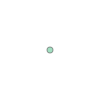

In [144]:
Point(coords[3])

In [162]:
i=3
l=LineString((Point(coords[i]),Point(coords[i+1])))

In [170]:
vect = (np.array(l.coords[1])-np.array(l.coords[0]))/l.length

In [168]:
step = l.length/(n-1)

In [175]:
point_=Point(np.array(point_.coords[0])+step*vect)
list(point_.coords[0])

[0.8334518526488687, 0.9078035191810869]